# An Introduction to Autoencoder Models

Autoencoders (AEs) are simple neural network models used to learn a low-dimensional representation of data through an encoding and a decoding process. AEs form an important part of machine learning history, as they are the direct predecessors of Variational Autoencoders (VAEs), a generative neural network model that quickly became the state-of-the-art in generative deep learning for several years, before Generative Adversarial Networks (GANs) and diffusion models were introduced.

In this notebook, I present an introduction to the theory behind AEs and an explicit implementation of a model for the classic MNIST dataset.

In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

from tqdm.notebook import tqdm

from umap import UMAP

Let $D$ be a dataset of points in $\mathbb{R}^n$ and define two multi-layer perceptrons $\phi:\mathbb{R}^n\rightarrow\mathbb{R}^m$ (the encoder) and $\psi:\mathbb{R}^m\rightarrow\mathbb{R}^n$ (the decoder) for some $m<n$.

The idea is that $\phi$ learns a low dimensional representation of the data and that $\psi$ learns how to reverse the process. To do so, we will minimize the reconstruction loss
$$\sum_{x\in D}\left\| x - (\psi\circ\phi)(x) \right\|_2^2$$

which is equivalent to minimizing the Mean Squared Error (MSE) loss.

We impose $m<n$ to force $\psi$ to learn the low dimensional structue of $D$ and not just a simple identity function (possibly for $m\ge n$).

In [2]:
class MLP(torch.nn.Module):
    def __init__(self, dims: list, activation: str | list[str] = "relu"):
        super().__init__()

        layers = []

        if type(activation) == str:
            act_fn = self._get_activation(activation)
            for i in range(len(dims) - 1):
                layers.append(torch.nn.Linear(dims[i], dims[i + 1]))
                if i < len(dims) - 2:
                    layers.append(act_fn())
        else:
            for i in range(max([len(dims),len(activation)])):
                if i < len(dims) - 1:
                    layers.append(torch.nn.Linear(dims[i], dims[i + 1]))
                if i < len(activation):
                    act_fn = self._get_activation(activation[i])
                    layers.append(act_fn())
            
        self.network = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor):
        return self.network(x)
    
    def _get_activation(self, name):
        return {
            "relu": torch.nn.ReLU,
            "tanh": torch.nn.Tanh,
            "sigmoid": torch.nn.Sigmoid,
            "gelu": torch.nn.GELU,
            "leaky_relu": torch.nn.LeakyReLU,
        }.get(name.lower(), torch.nn.ReLU)
    

class Autoencoder(torch.nn.Module):
    def __init__(self, encoder_dims: list, decoder_dims: list,
                 encoder_activation: str | list[str] = "tanh",
                 decoder_activation: str | list[str] = "tanh"):
        super().__init__()

        self.encoder = MLP(encoder_dims, encoder_activation)
        self.decoder = MLP(decoder_dims, decoder_activation)

    def forward(self, x):
        z = self.encoder(x)
        x_pred = self.decoder(z)
        return x_pred

I added an early stopping procedure, just as a simple good practice to avoid overfitting.

In [3]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        """
        patience: how many epochs to wait after last improvement
        min_delta: minimum improvement in val_loss to qualify as better
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


# Dataset loading and splitting

I used the MNIST dataset and downloaded it through the ```torch.datasets.MNIST``` class. If you are running this notebook for the first time, set ```dowload=True``` in the snipet above. The original downloading procedure returns 50k images for training and 10k for testing, but I want to add a validation set to address overfitting during training. 

After downloading the training data, lets split it in the classic **Train** (40k), **Validation** (10k) sets, using the ```torch.utils.data.random_split``` method.

Finally, we can group each one of these datasets in a batched-version of them, by using the ```torch.utils.data.DataLoader``` class.

In [4]:
full_train_dataset = MNIST(
    root='./data',
    train=True,
    transform=ToTensor(),
    download=False
)
test_dataset = MNIST(
    root='./data',
    train=False,
    transform=ToTensor(), 
    download=False
)

train_size = int(0.8 * len(full_train_dataset)) 
val_size = len(full_train_dataset) - train_size 
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=128,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False
)

For the following visualizations, I fixed each image to show the background as white and the digit as black using the ```Greys``` Matplotlib colormap. See an example above.

7


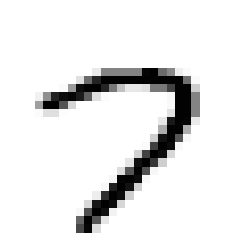

In [5]:
img, label = full_train_dataset.__getitem__(np.random.randint(0,len(full_train_dataset)))
fig,ax = plt.subplots(1,1,figsize=(3,3))
print(label)
ax.imshow(img[0],cmap="Greys")
ax.yaxis.set_inverted(True)
ax.axis("off")
plt.show()

# Model

I will use a small autoencoder structure with only one hidden layer for each MLP (encoder $\phi$ and decoder $\psi$), with only ReLU activations, except for the final layer at the decoder which will have a sigmoid function, since the original image values range from 0 to 1.

In [6]:
autoencoder = Autoencoder(
    encoder_dims=[784,128,64],
    decoder_dims=[64,128,784],
    encoder_activation=["relu","relu"],
    decoder_activation=["relu","sigmoid"]
).cuda()

# Training Strategy

As I have stated before, the original idea is to minimize the reconstruction error of the training images. But as we have divided each dataset into batches $B_0,\dots,B_{k-1}$ we will instead minimize the reconstruction error on each batch, sequentially. For this, we will use the ADAM optimizer procedure ```torch.optim.ADAM``` as follows

$$L(\theta_t) = \sum_{x\in B_{t\ (\text{mod}\ k)}}\left\|x-(\psi\circ\phi)(x;\theta_{t-1})\right\|_2^2$$
$$\theta_t \leftarrow \text{ADAM}\left[L(\theta_t), \beta_1,\beta_2,\eta\right]$$

Then, to evaluate trainig performance, we will compute the average batch reconstruction error. Finally, to address overfitting, we will compute the average batch reconstruction error on the validation set and if it does not improve on 5 contiguous epochs, the training will stop.

In [7]:
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(autoencoder.parameters(),lr=1e-3)
history = {"Train":[], "Val":[]}

In [8]:
epochs = 20
early_stopping = EarlyStopping(patience=5, min_delta=1e-4)

pbar = tqdm(range(epochs), desc="Training")

for epoch in pbar:

    autoencoder.train()
    train_losses = []

    for x_batch, _ in train_loader:
        x_batch = x_batch.cuda().reshape(-1,28*28)
        optim.zero_grad()
        outputs = autoencoder(x_batch)
        loss = loss_fn(outputs, x_batch)
        loss.backward()
        optim.step()
        train_losses.append(loss.item())

    avg_train_loss = sum(train_losses) / len(train_losses)

    autoencoder.eval()
    val_losses = []

    with torch.no_grad():
        for x_batch, _ in val_loader:
            x_batch = x_batch.cuda().reshape(-1,28*28)
            outputs = autoencoder(x_batch)
            loss = loss_fn(outputs, x_batch)
            val_losses.append(loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    history["Train"].append(avg_train_loss)
    history["Val"].append(avg_val_loss)

    pbar.set_postfix(train_loss=f"{avg_train_loss:.4f}", val_loss=f"{avg_val_loss:.4f}")

    early_stopping.step(avg_val_loss)
    if early_stopping.early_stop:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

Training:   0%|          | 0/20 [00:00<?, ?it/s]

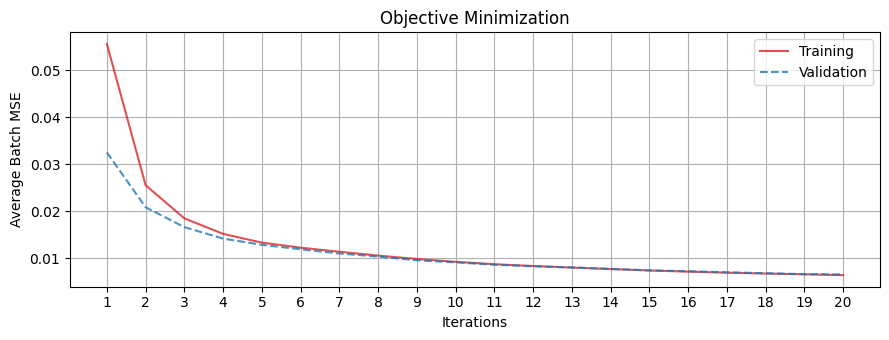

In [9]:
fig,ax = plt.subplots(1,1,figsize=(9,3.5))

ax.set_title("Objective Minimization")
ax.set_ylabel("Average Batch MSE")
ax.set_xlabel("Iterations")

ax.plot(
    history["Train"],
    label="Training",
    color="tab:red",
    alpha=0.8
)
ax.plot(
    history["Val"],
    label="Validation",
    color="tab:blue",
    alpha=0.8,
    linestyle="--"
)

n_results = len(history["Train"])

ax.set_xticks(
    np.arange(0,n_results),
    np.arange(1,n_results+1)
)
ax.grid()
ax.legend()
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

# Image Reconstruction

To show model's performance, lets select a random image of the test dataset and apply $\phi$ and then $\psi$ to it.

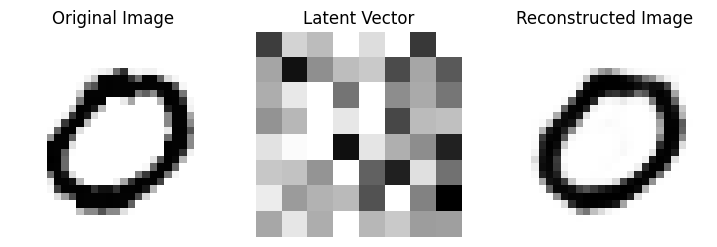

In [10]:
img, label = test_dataset.__getitem__(np.random.randint(0,len(test_dataset)))
with torch.no_grad():
    img_latent = autoencoder.encoder(img.flatten().cuda())
    img_reconstructed = autoencoder.decoder(img_latent)

fig,ax = plt.subplots(1,3,figsize=(9,3))

ax[0].set_title("Original Image")
ax[0].imshow(
    img[0],
    cmap="Greys"
)
ax[0].axis("off")

ax[1].set_title("Latent Vector")
ax[1].imshow(
    img_latent.reshape(8,8).cpu(),
    cmap="Greys"
)
ax[1].axis("off")

ax[2].set_title("Reconstructed Image")
ax[2].imshow(
    img_reconstructed.reshape(28,28).cpu(),
    cmap="Greys"
)
ax[2].axis("off")

plt.show()

# Perturbation of the Latent Vectors

Similarly, lets select a random image of the test dataset, but now, we perturb the latent vector by adding random Gaussian noise and then, decode the noisy version.

The first image is the original and the following are noisy reconstructions. Note that these neighbours are quite similar to the original one, but with slight differences. Nevertheless, such neighbors are not perfect nor very different amongst them, revealing one of the principal weaknesses of autoencoders.

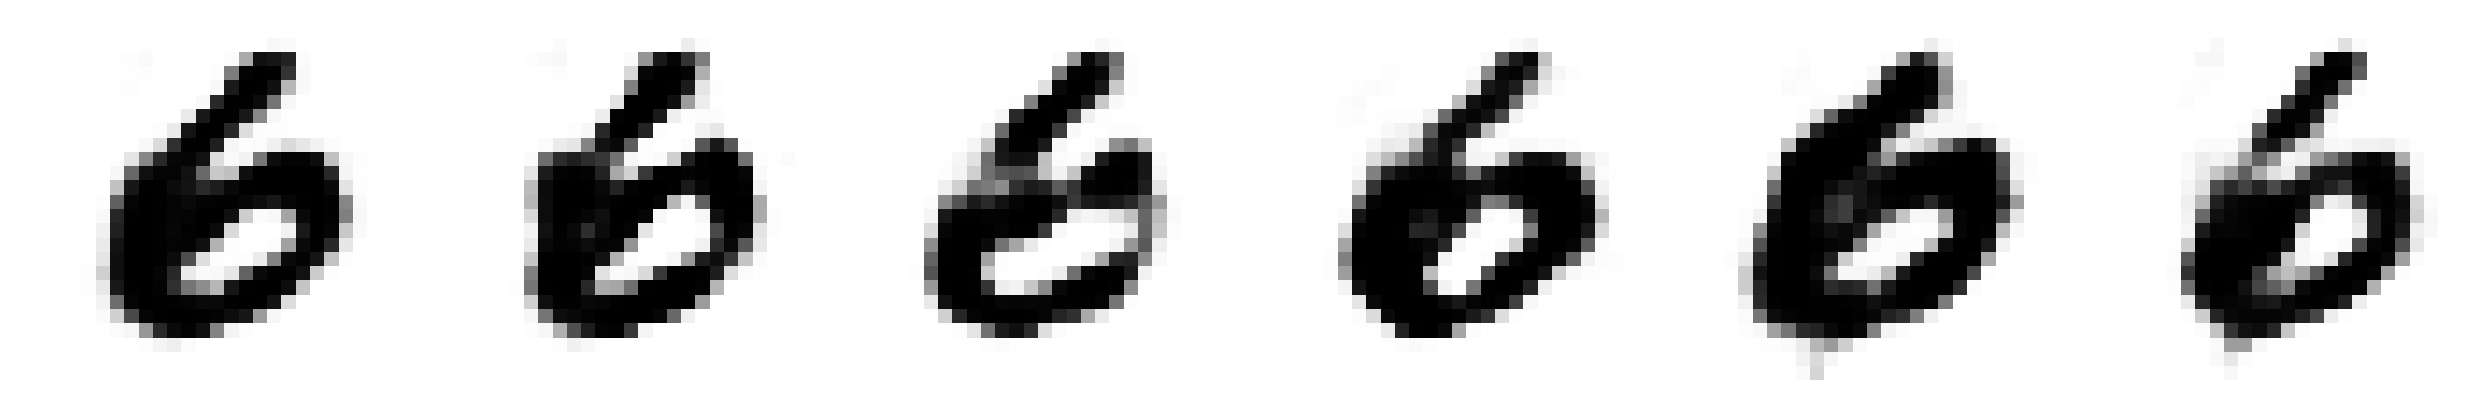

In [11]:
sigma = 1.3

img, label = test_dataset.__getitem__(np.random.randint(0,len(test_dataset)))

with torch.no_grad():
    img_latent = autoencoder.encoder(img.flatten().cuda())
    img_reconstructed = autoencoder.decoder(img_latent)

    fig,ax = plt.subplots(1,6,figsize=(25,5))
    
    ax[0].imshow(
            img_reconstructed.reshape(28,28).cpu(),
            cmap="Greys"
        )
    ax[0].axis("off")
    
    for i in range(1,6):
        neigh = autoencoder.decoder(img_latent + torch.randn(64,device="cuda")*sigma)
        ax[i].imshow(
                neigh.reshape(28,28).cpu(),
                cmap="Greys"
        )
        ax[i].axis("off")

plt.tight_layout()
plt.show()

# Structre Preservation in the Latent Space

To demosntrate that the autoencoder's latent space actually learns how to represent the data, I used the UMAP dimension reduction algorithm to compare the projection of a sample of the original data and its corresponding latent version.

In [12]:
sample_size = 5000

indices = np.random.choice(np.arange(len(train_dataset)), sample_size)
samples = [train_dataset[i] for i in indices]

data = torch.stack([x[0] for x, _ in samples]).reshape(-1,28*28)
labels = torch.tensor([y for _, y in samples])

with torch.no_grad():
    latent_data = autoencoder.encoder(data.cuda()).cpu().numpy()

umap_original = UMAP(
    n_neighbors=10,
    n_components=2,
    metric="euclidean"
).fit_transform(data)

umap_latent = UMAP(
    n_neighbors=10,
    n_components=2,
    metric="euclidean"
).fit_transform(latent_data)

Note that the high level structures are very similar, as clusters of data seem to be preserved on the latent space.

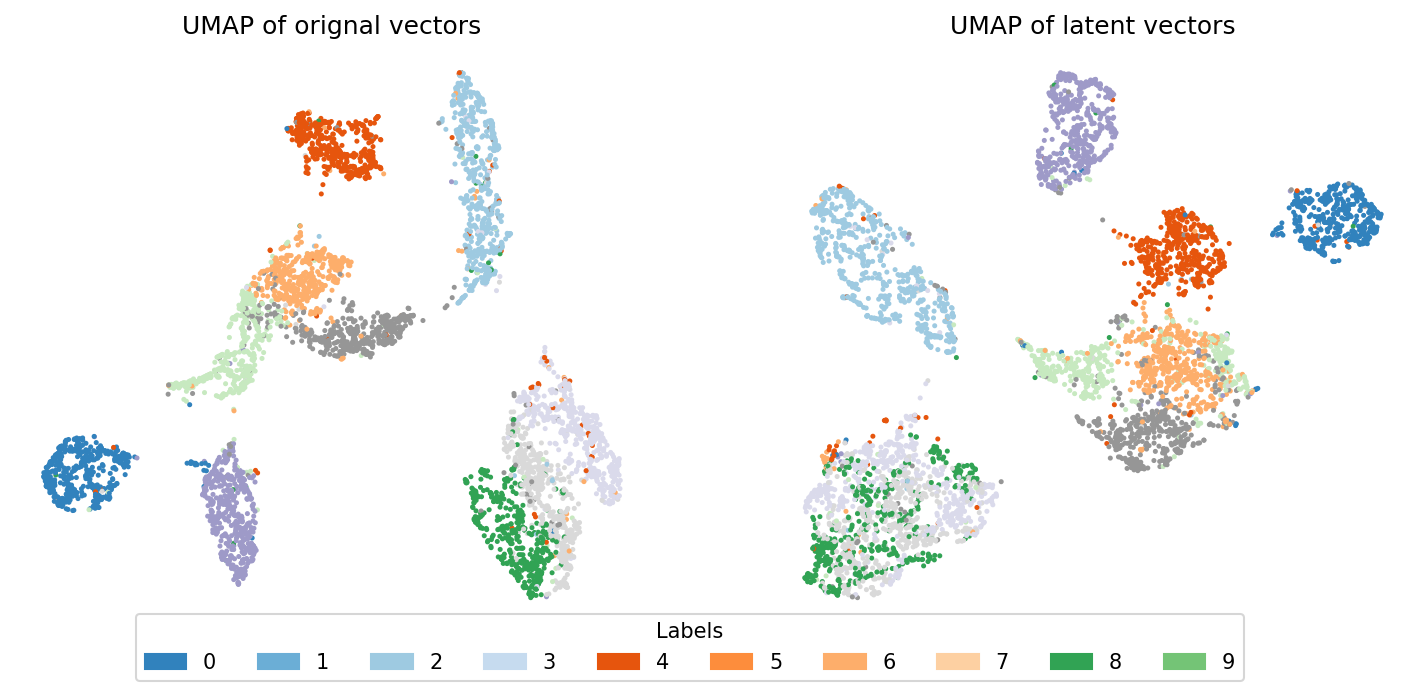

In [13]:
fig,ax = plt.subplots(1,2,figsize=(12,5), dpi=150)

ax[0].set_title("UMAP of orignal vectors")
ax[0].scatter(
    *umap_original.T,
    c=labels,
    cmap="tab20c",
    marker=".",
    s=8
)
ax[0].axis("off")
ax[1].set_title("UMAP of latent vectors")
ax[1].scatter(
    *umap_latent.T,
    c=labels,
    cmap="tab20c",
    marker=".",
    s=8
)
ax[1].axis("off")

unique_labels = np.unique(labels)
cmap = plt.colormaps.get_cmap("tab20c")
handles = [mpatches.Patch(color=cmap(i), label=str(lbl)) for i, lbl in enumerate(unique_labels)]

fig.legend(
    handles=handles,
    title="Labels",
    loc="lower center",
    bbox_to_anchor=(0.5, 0.02),
    ncol=len(unique_labels)
)

plt.show()

# Interpolation in the original space

An interpolation between two points $a,b\in\mathbb{R}^n$ is a function $I:[0,1]\rightarrow\mathbb{R}^n$ such that $I(0)=a$ and $I(1)=b$. 

Applications of interpolation are found everywhere, from finite-diference differential equations solvers, to TV (classical) artificial frame generation (24fps -> 60fps for multimedia content). Also, we usually desire to have an interpoltion that produces a smooth transition betwen points.

Autoencoders have proven to work well as interpolators, so in this section I give an example of it, by comparing its results with the well known *linear interpolation*.

In [14]:
def interpolation(images):
    n_steps = len(images)
    fig,ax = plt.subplots(1,n_steps,figsize=(5*n_steps,5))
    for i in range(n_steps):
        ax[i].imshow(
                1-images[i], # the 1-x is used to invert the color scheme (background to white and character to black).
                cmap="grey"
        )
        ax[i].axis("off")
    plt.show()

For this experiment, we first select two random images from the test dataset.

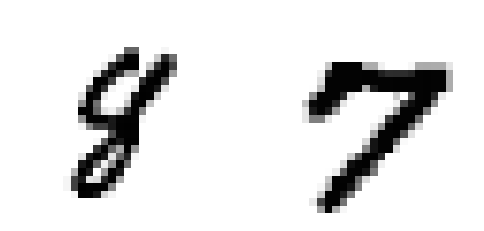

In [15]:
img1, _ = test_dataset.__getitem__(np.random.randint(0,len(test_dataset)))
img2, _ = test_dataset.__getitem__(np.random.randint(0,len(test_dataset)))

fig,ax = plt.subplots(1,2,figsize=(6,3))
ax[0].imshow(
    img1.reshape(28,28),
    cmap="Greys"
)
ax[0].axis("off")
ax[1].imshow(
    img2.reshape(28,28),
    cmap="Greys"
)
ax[1].axis("off")
plt.show()

## Linear Interpolation

A linear interpolation between $a$ and $b$ has the form of a straight line segment, and is given by
$$I_{\text{linear}}(t) = tb+(1-t)a$$

In [16]:
def linear_interpolation(img1, img2,n_steps):
    t = torch.linspace(0,1,n_steps).reshape(-1,1,1)
    X = img2*t + img1*(1-t)
    interpolation(X)

Linear interpolation is the simplest one of all, but it produces kind of a *fade-in* / *fade-out* PowerPoint transition.

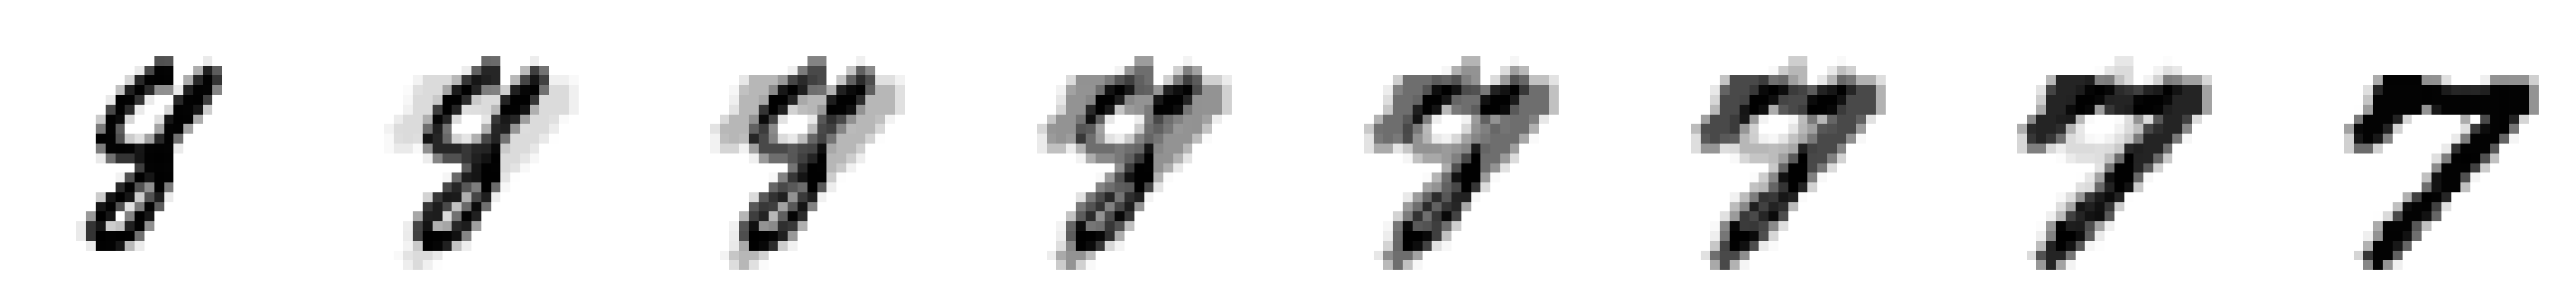

In [17]:
linear_interpolation(img1, img2, 8)

## Autoencoder Interpolation

Note that if we explore the latent space through a region $\Omega$, then $\psi(\Omega)$ will reveal the original space structure that is encoded in it.

Hence, if $\Omega$ is the image of an interpolation $I$ in the latent space, then $\psi\circ I $ is approximately an interpolation in the original space of the points $\psi\circ I (0)$ and $\psi\circ I (1)$.

In paticular, given two points $x_1,x_2$ in the original space and a linear interpolator in the latent space between $\phi(x_1)$ and $\phi(x_2)$ then, an approximate non-linear interpolation of $x_1$ and $x_2$ is given by
$$\hat I(t) = \psi\left(t\phi(x_2)+(1-t)\phi(x_1)\right)$$

In [18]:
def autoencoder_interpolation(img1, img2, n_steps):
    t = torch.linspace(0,1,n_steps,device="cuda").reshape(-1,1)
    with torch.no_grad():
        z1 = autoencoder.encoder(img1.flatten().cuda())
        z2 = autoencoder.encoder(img2.flatten().cuda())
        Z = z2*t + (1-t)*z1
        X = autoencoder.decoder(Z).reshape(-1,28,28).cpu()
    interpolation(X)

Thanks to structure preservation in the latent space, this interpolation seems to prodce a smoother morphing between $x_1$ and $x_2$.

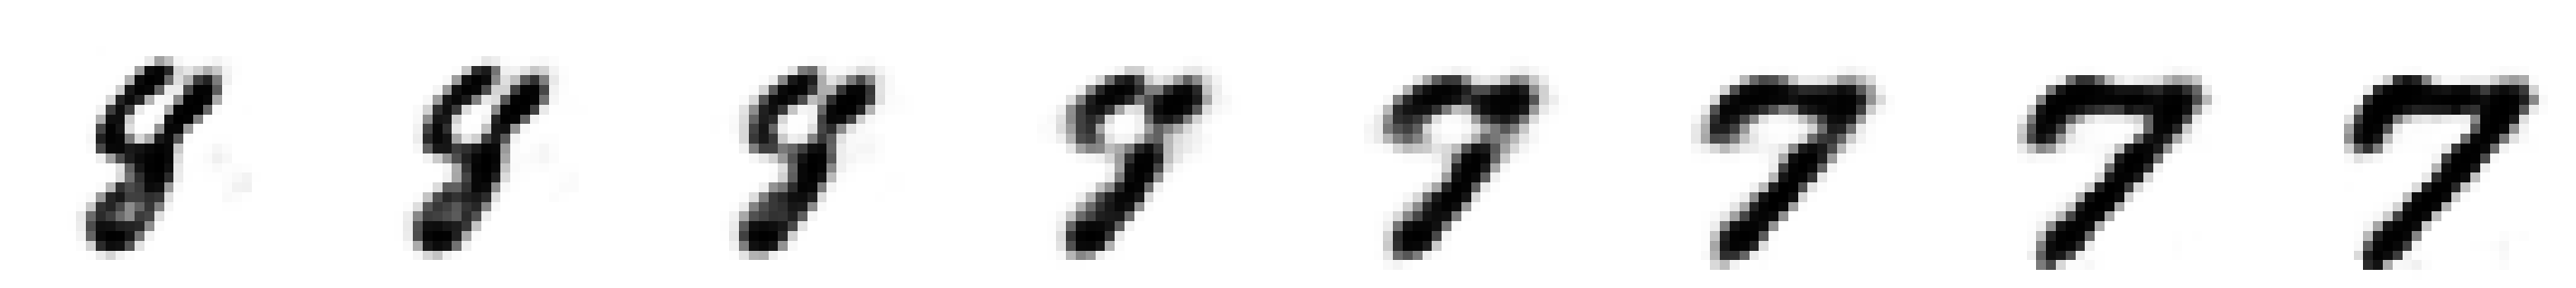

In [19]:
autoencoder_interpolation(img1, img2, 8)